***by: Adam Gogacz [(d-Analytics)](https://d-analytics.com/)***

Copyright 2022 d-Analytics. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Signal Model

The **pilot** $p(t)$ is a *linear* sweep/chirp ranging between $f_0$ and $f_1$ Hz,

$$
p(t) = \sin(\phi(t))\quad t\in[0,T]
$$

where the true phase $\phi$ is given as,

$$
\phi(t) := 2 \pi \Big(f_0 t + \frac{f_1 - f_0}{2 T} t^2 \Big), \quad t\in[0,T]
$$

and the **transmitted signal** $S(t)$ is given as the sum of the *amplitude and phase corrupted pilot signal* with a stationary (wss) Gaussian process $N\sim \mathcal{GP}(0,k_N(t-t'))$. The phase distortion $\{\Phi(t)\}_{t\in[0,T]}$ is also modeled as a stationary Gaussian process, $\Phi\sim \mathcal{GP}(0,k_\Phi(t-t'))$, whereas the amplitude distortion, $\{A(t)\}_{t\in[0,T]}$, is a modeled as a weakly stationary stochastic process ($wss$) with $A(t) \sim \mathsf{Rayleigh}(\sigma_A)$. Hence,

$$
S(t) := A(t) \sin\Big(2 \pi \Big(f_0 t + \frac{f_1 - f_0}{2 T} t^2 \Big) + \Phi(t) \Big) + N(t), \quad 
$$

I'll assume that all auto-covariance functions for $N,\Phi$, and $A$, generically denoted as $K_{XX}(t,t')\stackrel{wss}{=}K_{XX}(t-t',0)=K_{XX}(t-t')$, are of the following functional form,

$$
K_{XX}(t-t',0) = \sigma_X^2 \mathbf{1}_{\{0\}} (t-t')
$$

where $\mathbf{1}_{\{0\}}$ is the indicator function for the singleton set $\{0\}$; this assumption is reasonable for disrete and sufficiently coarsely sampled data.

# Time Series: Matched-Filter Pulse Compression

If $X(t)$ is a stochastic processes (time-series) obtained from the convolution of a sparse-spike series $R(t)$,

$$
R(t) = \sum_{i=0}^\infty r_i \delta(t-t_i), \quad t_i \geq 0,\ \delta \text{ is the Dirac distribution}
$$

with a signal $S(t)$,

$$
X(t) = \int_{-\infty}^\infty R(\tau) S(t-\tau)\,d\tau
$$

then, *matched-filtering* is a pulse compression technique where the time-series $X(t)$ is cross-correlated with the signal $S(t)$,

$$\begin{aligned}
Y(t) &:= \int_{-\infty}^\infty X(\xi) S(t+\xi)\, d\xi \\[1em]
&= \int_{-\infty}^\infty \int_{-\infty}^\infty R(\tau) S(\xi-\tau)\, d\tau S(t+\xi)\, d\xi\\[1em]
&= \int_{-\infty}^\infty \int_{-\infty}^\infty R(\tau) S(\xi-\tau) S(t+\xi)\, d\xi \, d\tau \\[1em]
& = \int_{-\infty}^\infty R(\tau) W(t-\tau)\,d\tau
\end{aligned}$$

such that,

$$
W(t) = \int_{-\infty}^\infty S(\tau) S(t+\tau)\,d\tau
$$

and we recognize that $Y(t)$ is the convolution of the sparse-spike series $R(t)$ with the wavelet given by $W(t)$. Moreover, we recognize $W(t)$ as the autocorrelation function of $S(t)$, which we can show to be well concentrated around $t=0$.

In practice, we seldom if ever, know the actual signal $S(t)$. What we generally have is the *intended* signal or the **pilot**, which is the modelled noise and distrotion free transmission. However; if the phase and amplitude distortions are low, then the approximation of the transmitted signal with the pilot signal is valid.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate
from scipy.stats import rayleigh
%matplotlib inline
plt.rcParams.update({'font.size': 8})

In [ ]:
def gen_timeseries(f0, f1, T, dt, R, var_phi, var_n, scale_A):
  """Linear sweep generator with front-padding"""
  gensig = lambda f0,f1,T,x,phi: np.sin(2.*np.pi*(f0*x+((f1-f0)/(2*T))*x**2) + phi)

  assert f0 > 0 and f1 > f0, 'The following condition was not met: 0 < f0 < f1'
  siglen = int(np.ceil(T/dt))
  t_range = np.linspace(0,T,siglen)

  Phi = np.random.normal(loc=0,scale=np.sqrt(var_phi),size=t_range.size)
  if scale_A > 0:
    A = rayleigh.rvs(loc=0,scale=scale_A,size=t_range.size)
    print(f'mean(A) = {A.mean()}')
  else:
    A = np.ones(t_range.size)
  
  P_distort = A * gensig(f0,f1,T,t_range,Phi)
  S = np.convolve(R, P_distort, mode='full')
  S += np.random.normal(loc=0,scale=np.sqrt(var_n),size=S.size)
  pilot = gensig(f0,f1,T,t_range,0*Phi)

  return S, pilot

In [ ]:
def plotResults(sig,titlestr):   
  fig, axs=plt.subplots(nrows=1, ncols=1, figsize=(12,3), dpi=150)
  idxSigmin, idxSigmax = 0, len(sig)
  idx=np.arange(len(sig))
  axs.plot(idx[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
  axs.set_xlabel('Sample')
  axs.set_xlim(idx[0],idx[-1])
  axs.set_title(label=titlestr,fontdict=None, loc='center', pad=None)
 
  #fig.tight_layout()

mean(A) = 2.9359561570605086


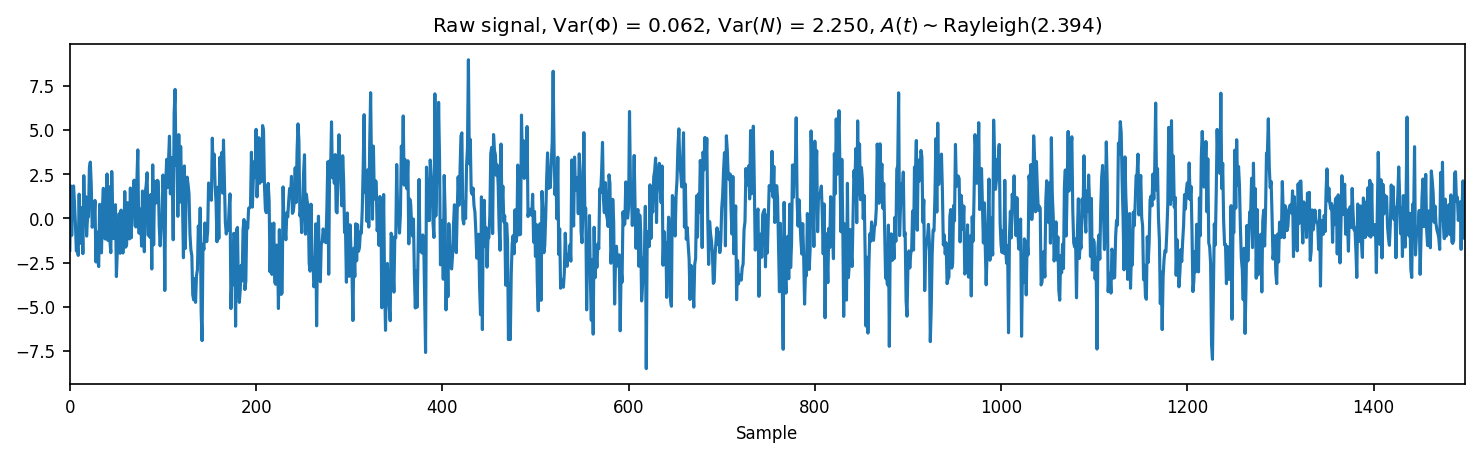

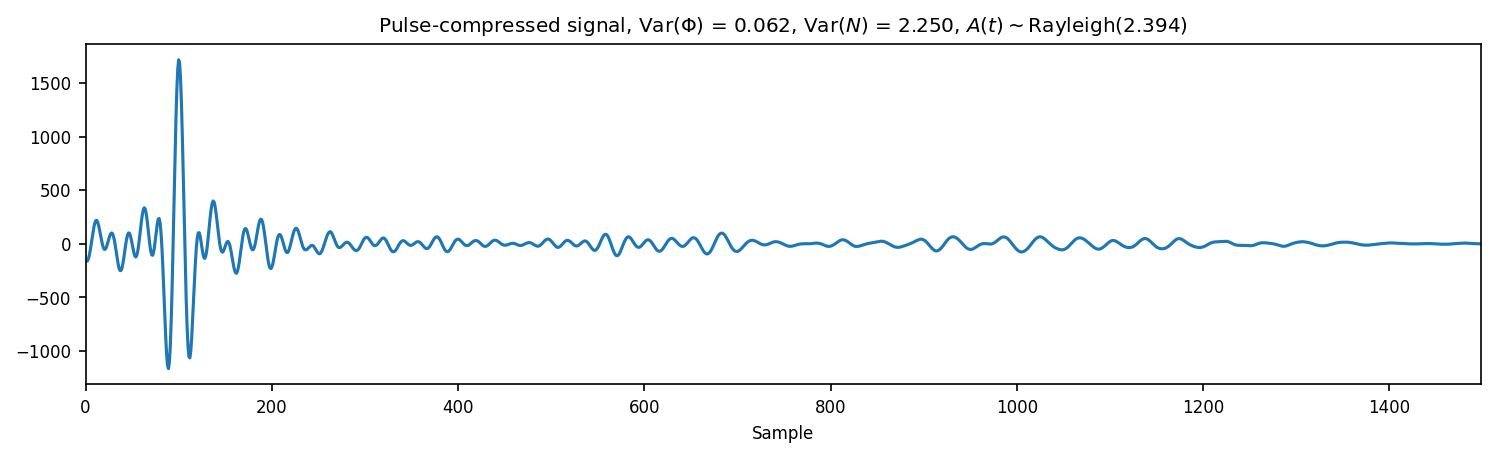

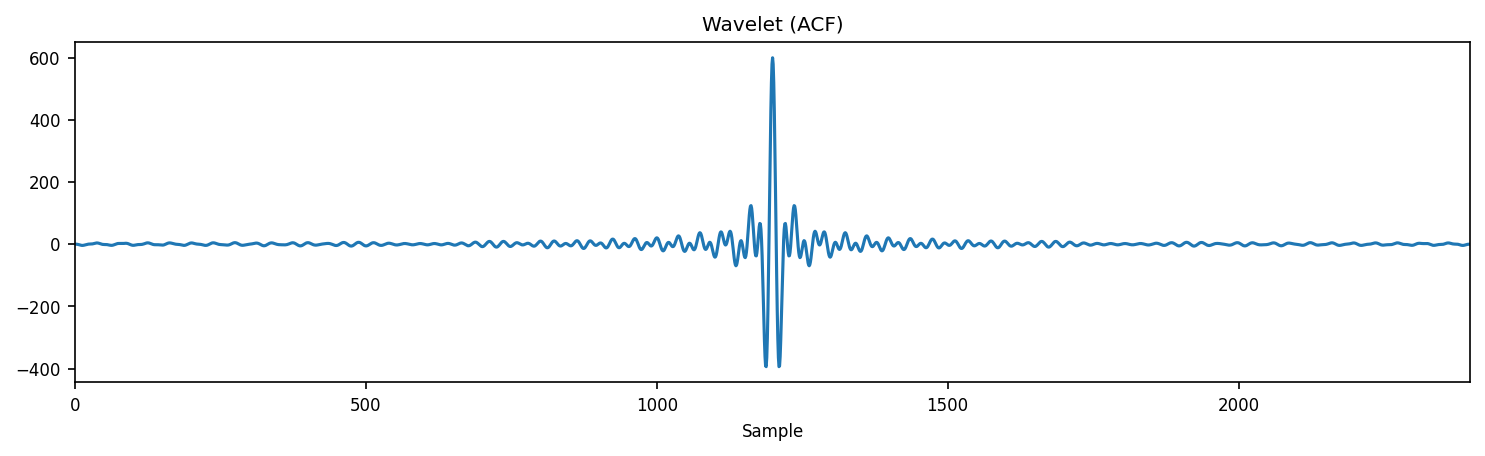

In [ ]:
#--- signal and noise/distortions parameters
R = np.zeros(300,dtype=float)
R[R.size//3] = 1

var_phi = 0.25**2
var_n = 1.5**2
scale_A = 3*np.sqrt(2/np.pi)

#--- generate signal
signal, pilot = gen_timeseries(f0=1000.0, f1=3000,T=24e-3, dt=1/50e3, R=R, var_phi=var_phi, var_n=var_n, scale_A=scale_A)

#--- plot raw signal
plotResults(signal, r'Raw signal, ' + r'$\mathsf{Var}(\Phi)$ = ' + f'{var_phi:.3f}, ' + r'$\mathsf{Var}(N)$ = ' + f'{var_n:.3f}, '
          + r'$A(t) \sim \mathsf{Rayleigh}$' + f'({scale_A:.3f})')

#--- plot match-filtered time-series
filt = pilot
pc_signal = correlate(signal,filt,mode='full')
plotResults(pc_signal[len(filt)-1:],r'Pulse-compressed signal, ' + r'$\mathsf{Var}(\Phi)$ = ' + f'{var_phi:.3f}, ' + r'$\mathsf{Var}(N)$ = ' + f'{var_n:.3f}, '
          + r'$A(t) \sim \mathsf{Rayleigh}$' + f'({scale_A:.3f})')

#--- plot ACF 
plotResults(correlate(pilot, pilot, mode='full'),'Wavelet (ACF)')